In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!git clone https://github.com/dorabangs/dog_cat.git

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import os
import time
import matplotlib.pyplot as plt
import numpy as np
import copy
%matplotlib inline

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
data_transforms = {
    'train':transforms.Compose([ # Composes several transforms together.
        transforms.RandomResizedCrop(224), # size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        # Sequence of means for each channel, Sequence of standard deviations for each channel.
    ]),
    'val':transforms.Compose([
        transforms.Resize(300),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
data_dir = '/content/dog_cat/dog_cat'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

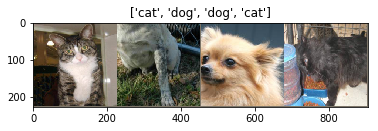

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train'])) 

# Make a grid from batch
out = torchvision.utils.make_grid(inputs) 
imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## **구조만 불러온 뒤 전체 학습**

In [9]:
resnet18 = models.resnet18()
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 2)
resnet18 = resnet18.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
resnet18_ft = train_model(resnet18, criterion, 
                          optimizer_ft, 
                          exp_lr_scheduler,
                          num_epochs=25)

Epoch 1/25
----------
train Loss: 0.7651 Acc: 0.5099
val Loss: 0.7263 Acc: 0.5000

Epoch 2/25
----------
train Loss: 0.7600 Acc: 0.5000
val Loss: 1.0796 Acc: 0.5196

Epoch 3/25
----------
train Loss: 0.7685 Acc: 0.5594
val Loss: 1.1384 Acc: 0.5098

Epoch 4/25
----------
train Loss: 0.8013 Acc: 0.5000
val Loss: 0.6993 Acc: 0.5196

Epoch 5/25
----------
train Loss: 0.7755 Acc: 0.5693
val Loss: 0.8055 Acc: 0.5588

Epoch 6/25
----------
train Loss: 0.8397 Acc: 0.5297
val Loss: 0.8655 Acc: 0.5196

Epoch 7/25
----------
train Loss: 0.6390 Acc: 0.6139
val Loss: 0.5931 Acc: 0.6863

Epoch 8/25
----------
train Loss: 0.6668 Acc: 0.6089
val Loss: 0.6107 Acc: 0.6275

Epoch 9/25
----------
train Loss: 0.6450 Acc: 0.6485
val Loss: 0.6185 Acc: 0.6373

Epoch 10/25
----------
train Loss: 0.6132 Acc: 0.6683
val Loss: 0.6786 Acc: 0.6765

Epoch 11/25
----------
train Loss: 0.6447 Acc: 0.6188
val Loss: 0.6523 Acc: 0.6078

Epoch 12/25
----------
train Loss: 0.6435 Acc: 0.6436
val Loss: 0.6327 Acc: 0.6275

E

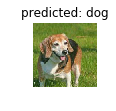

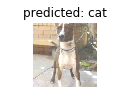

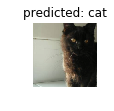

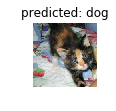

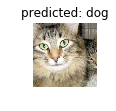

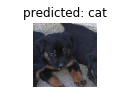

In [11]:
visualize_model(resnet18)

## **pretrained모델 불러온 뒤 fine-tuning**

In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.7290 Acc: 0.6139
val Loss: 0.1758 Acc: 0.9314

Epoch 2/25
----------
train Loss: 0.5113 Acc: 0.7624
val Loss: 0.0789 Acc: 0.9902

Epoch 3/25
----------
train Loss: 0.6737 Acc: 0.7277
val Loss: 0.0529 Acc: 1.0000

Epoch 4/25
----------
train Loss: 0.4216 Acc: 0.7921
val Loss: 0.0607 Acc: 0.9902

Epoch 5/25
----------
train Loss: 0.4470 Acc: 0.8267
val Loss: 0.1156 Acc: 0.9314

Epoch 6/25
----------
train Loss: 0.6300 Acc: 0.7921
val Loss: 0.0875 Acc: 0.9412

Epoch 7/25
----------
train Loss: 0.3270 Acc: 0.8762
val Loss: 0.0893 Acc: 0.9510

Epoch 8/25
----------
train Loss: 0.3684 Acc: 0.8515
val Loss: 0.0677 Acc: 0.9706

Epoch 9/25
----------
train Loss: 0.4336 Acc: 0.8317
val Loss: 0.0742 Acc: 0.9510

Epoch 10/25
----------
train Loss: 0.4357 Acc: 0.8020
val Loss: 0.0616 Acc: 0.9804

Epoch 11/25
----------
train Loss: 0.3056 Acc: 0.8713
val Loss: 0.0521 Acc: 0.9902

Epoch 12/25
----------
train Loss: 0.3099 Acc: 0.8713
val Loss: 0.0569 Acc: 1.0000

E

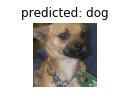

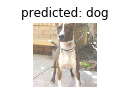

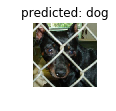

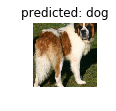

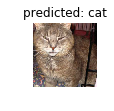

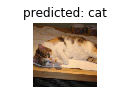

In [14]:
visualize_model(model_conv)